<a href="https://colab.research.google.com/github/swapniel99/shotworx/blob/main/ShotWorX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!unzip /gdrive/MyDrive/photos.zip -d . > /dev/null
%ls photos/ | wc -l

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
replace ./__MACOSX/._photos? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
499


In [ ]:
%pip install facenet_pytorch

In [ ]:
import os
import gc
import cv2
import torch
import itertools
import numpy as np
import pandas as pd
import sklearn.cluster as cluster
import seaborn as sns
from sklearn.decomposition import PCA
from facenet_pytorch import MTCNN, InceptionResnetV1
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm.notebook import tqdm_notebook

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()
print(f'Found device {device}')

Found device cuda


In [ ]:
mtcnn = MTCNN(device=device, post_process=True, select_largest=False, keep_all=True, thresholds=[0.7, 0.85, 0.95], margin=20)

In [ ]:
def img_transform(i):
  return i.permute(1, 2, 0).int().numpy()

def recover_from_std_image(processed_tensor):
  image_tensor = processed_tensor * 128.0 + 127.5
  img = img_transform(image_tensor)
  return img

def display(img):
  plt.imshow(recover_from_std_image(img))
  plt.axis('off')
  plt.show()

def face_detect_demo(img_name):
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  faces, probs = mtcnn(img, return_prob=True)
  print(f'{len(probs)} faces found.')
  if len(faces) == 1:
    plt.imshow(recover_from_std_image(faces[0]))
    plt.axis('off')
  else:
    fig, axes = plt.subplots(1, len(faces), figsize=(15, 15))
    for face, ax in zip(faces, axes):
        ax.imshow(recover_from_std_image(face))
        ax.axis('off')
  plt.show()

def get_faces(img_name):
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  faces, probs = mtcnn(img, return_prob=True)
  return faces

def show_faces_from_cluster(faces_df, cluster_id, num=9):
  faces = faces_df[faces_df['cluster']==cluster_id]
  if len(faces) >= num:
    faces = faces.sample(num).reset_index()['face']
  else:
    faces = faces.reset_index()['face']
  if len(faces) == 1:
    plt.imshow(recover_from_std_image(faces.loc[0]))
    plt.axis('off')
  else:
    fig, axes = plt.subplots(1, len(faces), figsize=(15, 15))
    for face, ax in zip(faces, axes):
        ax.imshow(recover_from_std_image(face))
        ax.axis('off')
  plt.show()

def show_images_from_cluster(faces_df, cluster_id, num=3):
  images = faces_df[faces_df['cluster']==cluster_id]
  if len(images) >= num:
    images = images.sample(num).reset_index()['image']
  else:
    images = images.reset_index()['image']
  for img_name in images:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(recover_from_std_image(img))
    plt.axis('off')
    plt.show()

In [ ]:
all_images_path = [f'photos/{x}' for x in os.listdir('photos') if '.jpg' in x.lower()]

In [ ]:
detected_faces = list()

In [ ]:
for i in tqdm_notebook(all_images_path, 'Progress'):
  for f in get_faces(i):
    if f is not None:
      detected_faces.append({'image': i,'face': f})

Progress:   0%|          | 0/499 [00:00<?, ?it/s]

In [ ]:
faces_df = pd.DataFrame(detected_faces)
faces_df['embeddings'] = None

In [ ]:
del mtcnn, detected_faces
gc.collect()
torch.cuda.empty_cache()

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
embeddings = list()
for chunk in np.array_split(faces_df, 10):
  aligned = torch.stack(list(chunk['face'])).to(device)
  embd = resnet(aligned).detach().cpu()
  del aligned
  embeddings += [[x.item() for x in e] for e in embd]
  del embd
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
faces_df['embeddings'] = embeddings

In [ ]:
del resnet, embeddings
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# def scatter_thumbnails(data, images, zoom=0.12, colors=None):
#     assert len(data) == len(images)

#     # reduce embedding dimentions to 2
#     x = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data

#     # create a scatter plot.
#     f = plt.figure(figsize=(22, 15))
#     ax = plt.subplot(aspect='equal')
#     sc = ax.scatter(x[:,0], x[:,1], s=4)
#     _ = ax.axis('off')
#     _ = ax.axis('tight')

#     # add thumbnails :)
#     for i in range(len(images)):
#         image = recover_from_std_image(images[i])
#         im = OffsetImage(image, zoom=zoom)
#         bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
#         ab = AnnotationBbox(im, x[i], xycoords='data',
#                             frameon=(bboxprops is not None),
#                             pad=0.02,
#                             bboxprops=bboxprops)
#         ax.add_artist(ab)
#     return ax

In [ ]:
# _ = scatter_thumbnails(faces_df.embeddings.tolist(), faces_df.face.tolist())
# plt.title('Facial Embeddings - Principal Component Analysis')
# plt.show()

In [ ]:
# def plot_clusters(data, images, algorithm, *args, **kwds):
#     labels = algorithm(*args, **kwds).fit_predict(data)
#     palette = sns.color_palette('deep', np.max(labels) + 1)
#     colors = [palette[x] if x >= 0 else (0,0,0) for x in labels]
#     ax = scatter_thumbnails(data, images, 0.12, colors)
#     plt.title(f'Clusters found by {algorithm.__name__}')
#     return labels

# clusters = plot_clusters(faces_df.embeddings.tolist(), faces_df.face.tolist(), cluster.DBSCAN, n_jobs=-1, eps=0.65, min_samples=2)

clusters = cluster.DBSCAN(n_jobs=-1, eps=0.55, min_samples=3).fit_predict(faces_df.embeddings.tolist())
faces_df['cluster'] = clusters

In [ ]:
faces_df.cluster.value_counts().sort_index()

-1     287
 0      45
 1      44
 2      18
 3      25
 4      21
 5     150
 6     149
 7      50
 8      51
 9      11
 10     37
 11    107
 12     74
 13     47
 14     57
 15     27
 16     52
 17     43
 18     19
 19     32
 20     22
 21     23
 22      7
 23     52
 24     23
 25     11
 26     11
 27     54
 28     15
 29      4
 30     11
 31      3
 32     10
Name: cluster, dtype: int64

-1


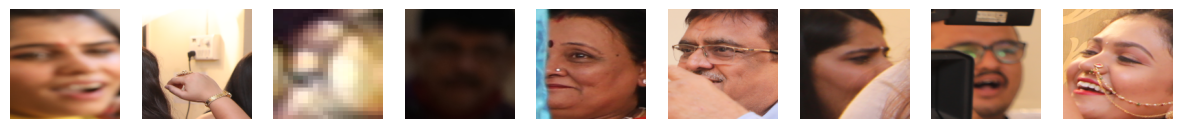

0


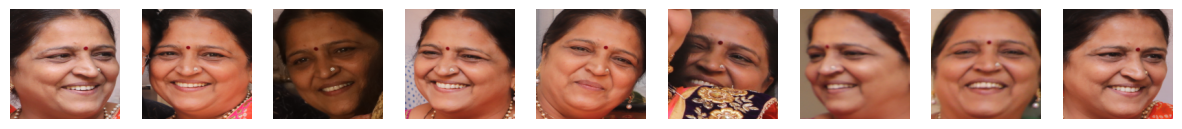

1


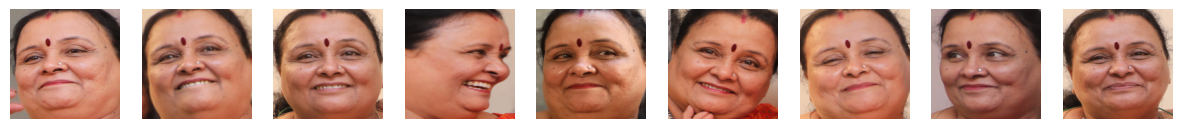

2


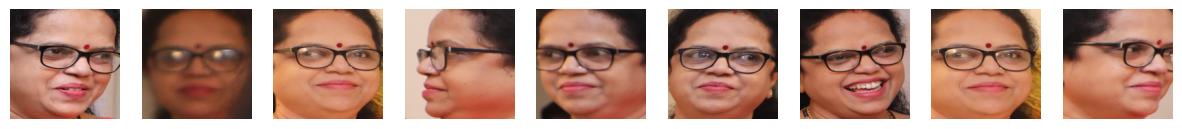

3


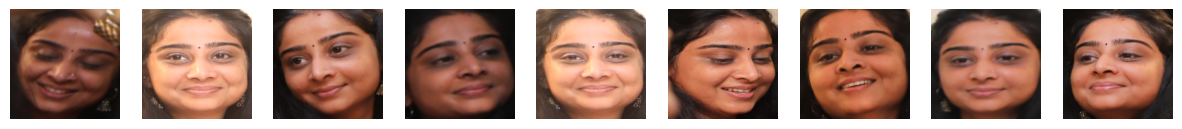

4


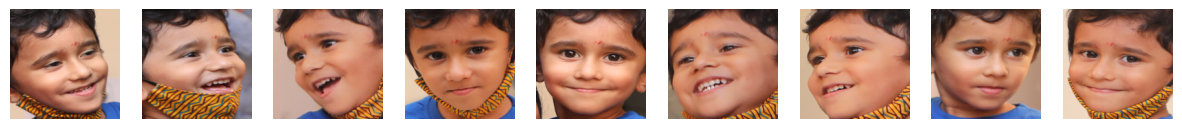

5


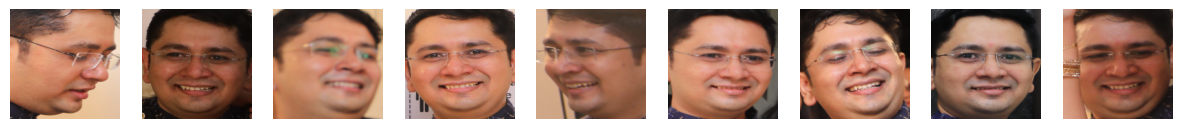

6


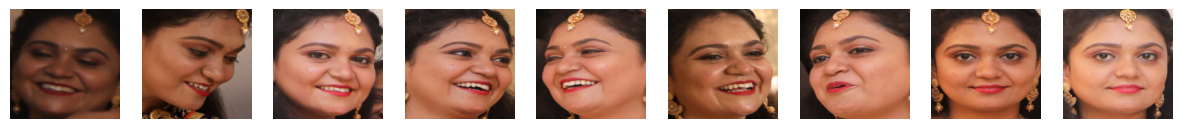

7


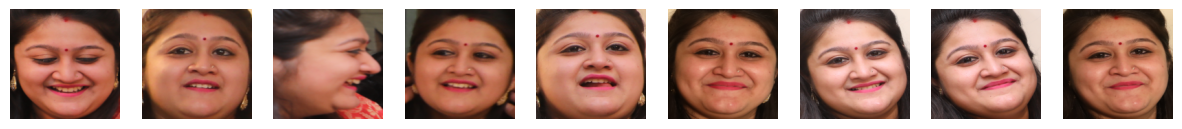

8


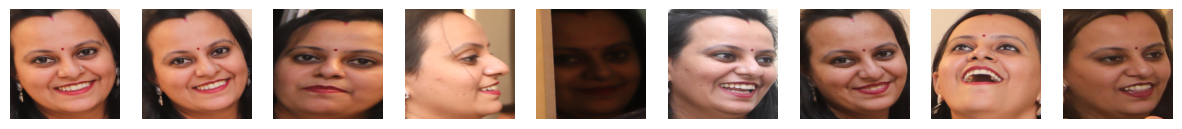

9


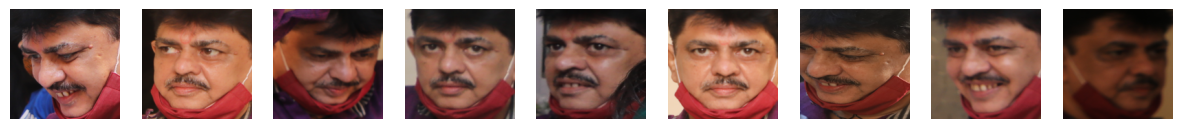

10


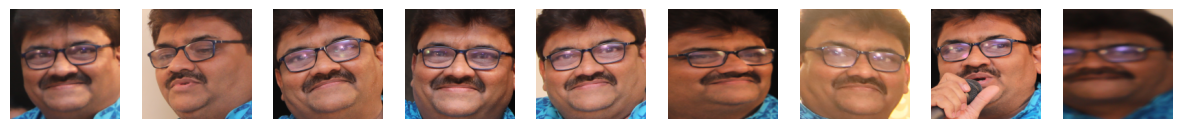

11


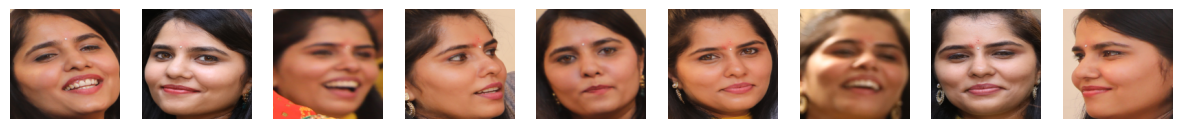

12


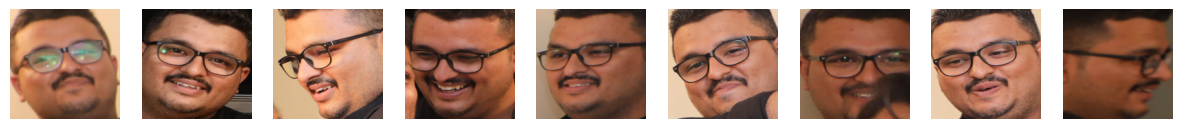

13


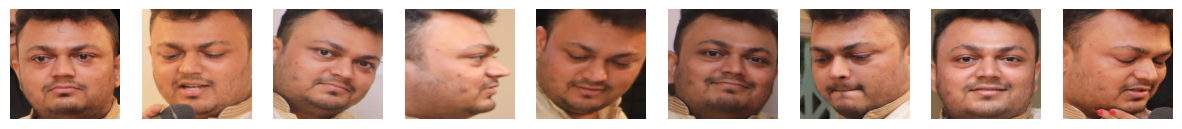

14


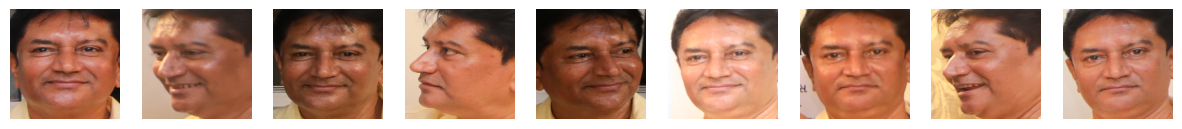

15


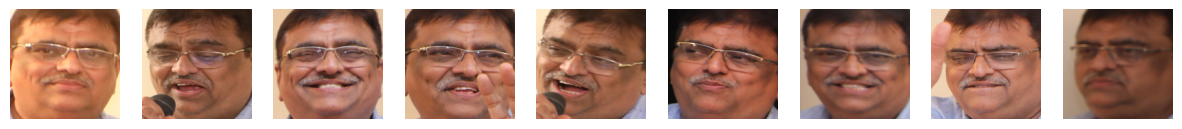

16


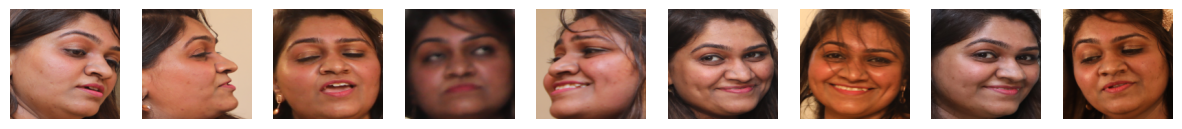

17


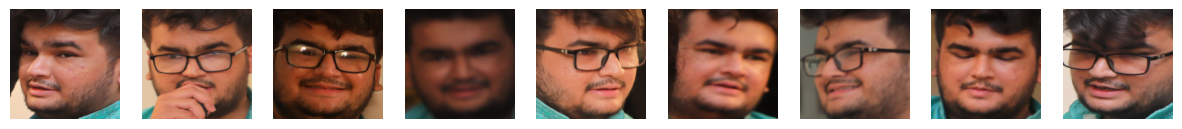

18


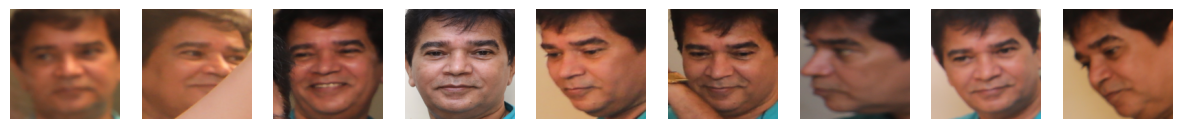

19


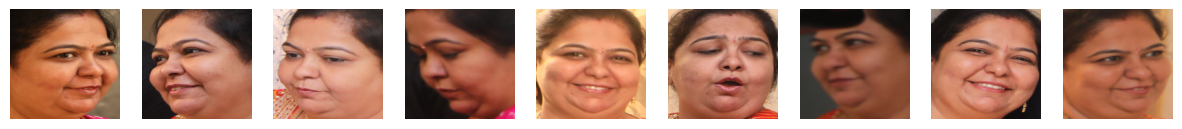

20


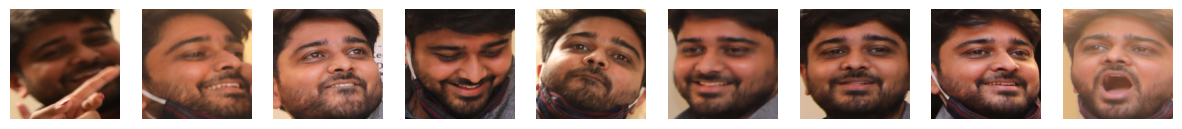

21


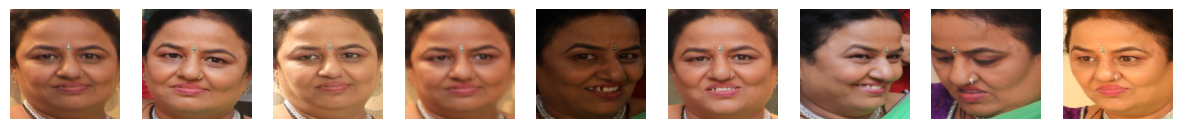

22


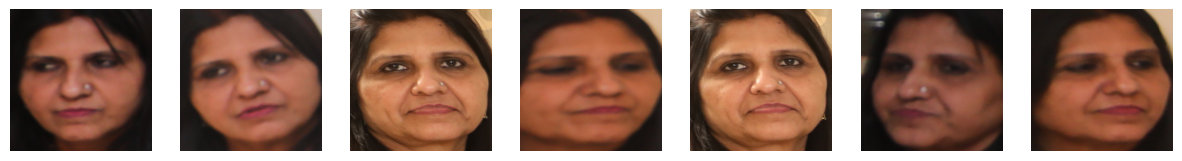

23


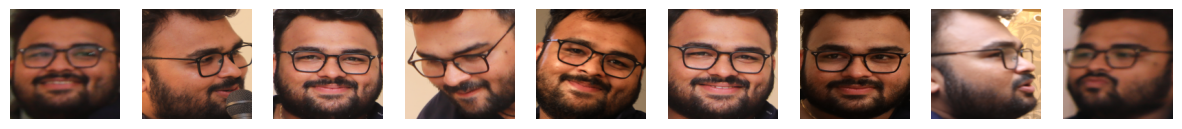

24


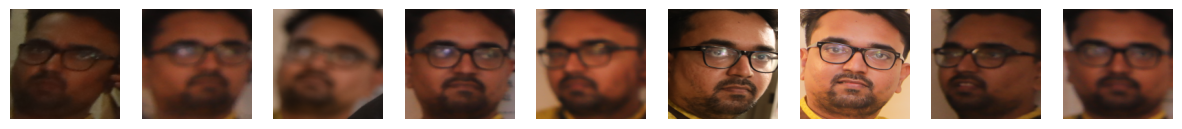

25


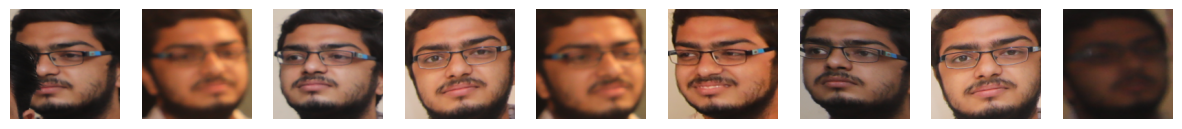

26


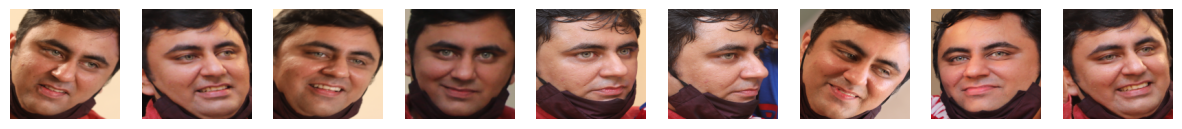

27


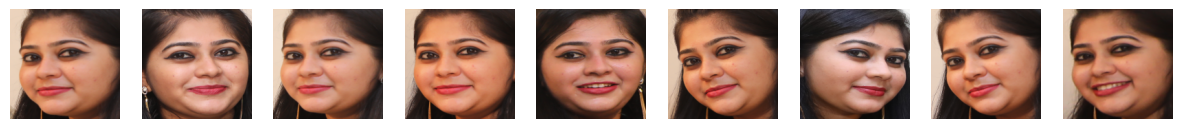

28


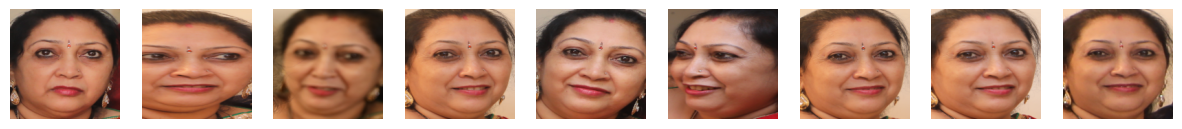

29


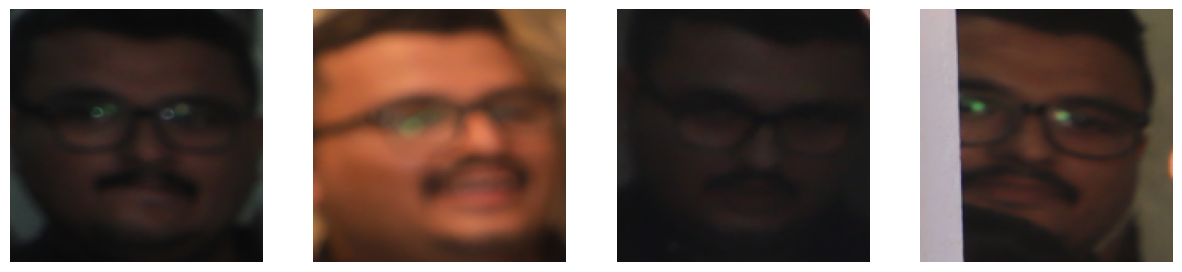

30


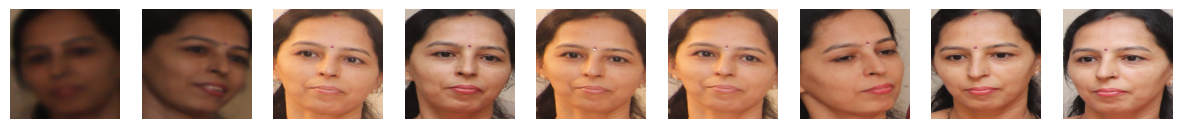

31


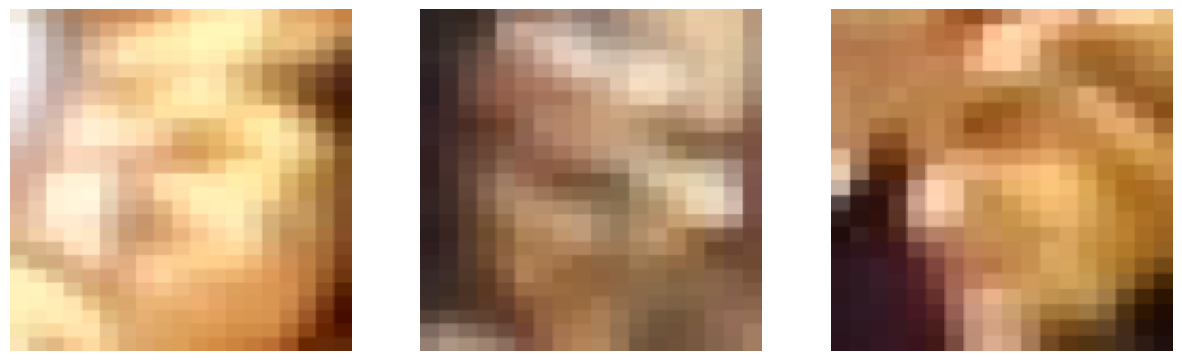

32


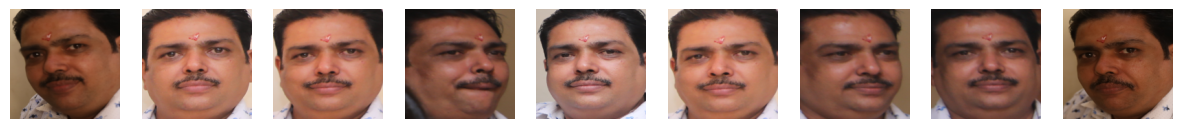

In [ ]:
for i in sorted(faces_df.cluster.unique()):
  print(i)
  show_faces_from_cluster(faces_df, i)